# Heart Attack Prediction using RandomForest

Installing pyspark in this notebook

In [103]:
!pip install pyspark

### Necessary imports

In [104]:
from pyspark.sql import SparkSession, types, functions, udf
from pyspark.sql.functions import col, mean, stddev, expr, Column, udf, countDistinct, when, expr
from pyspark.sql.functions import sum as _sum
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt
import seaborn as sns

### Initialializing Spark Session

In [105]:
spark = SparkSession.builder.master("local").appName("HeartAttackDataset").getOrCreate()

### Mounting the Drive

In [106]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importing the dataset using pyspark

In [107]:
df = spark.read.csv('/content/drive/MyDrive/archive/Medicaldataset.csv', header=True, inferSchema=True)

### Copying df in df

In [108]:
df2 = df

### Displaying the information or schema or formation of df

In [109]:
df.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Gender: integer (nullable = true)
 |-- Heart rate: integer (nullable = true)
 |-- Systolic blood pressure: integer (nullable = true)
 |-- Diastolic blood pressure: integer (nullable = true)
 |-- Blood sugar: double (nullable = true)
 |-- CK-MB: double (nullable = true)
 |-- Troponin: double (nullable = true)
 |-- Result: string (nullable = true)



### Checking the data by sampling first five rows using show

In [110]:
df.show(5)

+---+------+----------+-----------------------+------------------------+-----------+-----+--------+--------+
|Age|Gender|Heart rate|Systolic blood pressure|Diastolic blood pressure|Blood sugar|CK-MB|Troponin|  Result|
+---+------+----------+-----------------------+------------------------+-----------+-----+--------+--------+
| 63|     1|        66|                    160|                      83|      160.0|  1.8|   0.012|negative|
| 20|     1|        94|                     98|                      46|      296.0| 6.75|    1.06|positive|
| 56|     1|        64|                    160|                      77|      270.0| 1.99|   0.003|negative|
| 66|     1|        70|                    120|                      55|      270.0|13.87|   0.122|positive|
| 54|     1|        64|                    112|                      65|      300.0| 1.08|   0.003|negative|
+---+------+----------+-----------------------+------------------------+-----------+-----+--------+--------+
only showing top 5 

### Checking for null data which is 0 (Good to Proceed)

In [111]:
null_counts = df2.select([_sum(col(c).isNull().cast("int")).alias(c) for c in df2.columns])

In [112]:
null_counts.show()

+---+------+----------+-----------------------+------------------------+-----------+-----+--------+------+
|Age|Gender|Heart rate|Systolic blood pressure|Diastolic blood pressure|Blood sugar|CK-MB|Troponin|Result|
+---+------+----------+-----------------------+------------------------+-----------+-----+--------+------+
|  0|     0|         0|                      0|                       0|          0|    0|       0|     0|
+---+------+----------+-----------------------+------------------------+-----------+-----+--------+------+



### Checking for unique data to know how many facets of data are present

In [113]:
unique_counts = df2.agg(*(countDistinct(col(c)).alias(c) for c in df2.columns))

In [114]:
unique_counts.show() # Displaying unique data

+---+------+----------+-----------------------+------------------------+-----------+-----+--------+------+
|Age|Gender|Heart rate|Systolic blood pressure|Diastolic blood pressure|Blood sugar|CK-MB|Troponin|Result|
+---+------+----------+-----------------------+------------------------+-----------+-----+--------+------+
| 75|     2|        79|                    116|                      73|        244|  700|     352|     2|
+---+------+----------+-----------------------+------------------------+-----------+-----+--------+------+



### Assigning necessary labels

In [115]:
# Convert 'Blood sugar' column to integer type
df = df.withColumn('Blood sugar', col('Blood sugar').cast('int'))

# Replace values in 'Gender' column (1 -> 'Male', 0 -> 'Female')
df = df.withColumn('Gender', when(col('Gender') == 1, 'Male').when(col('Gender') == 0, 'Female'))

# Replace values in 'Result' column ('positive' -> 1, 'negative' -> 0)
df2 = df2.withColumn('Result', when(col('Result') == 'positive', 1).when(col('Result') == 'negative', 0))

# Optional: Show the transformed DataFrame to verify changes
df.show(5)


+---+------+----------+-----------------------+------------------------+-----------+-----+--------+--------+
|Age|Gender|Heart rate|Systolic blood pressure|Diastolic blood pressure|Blood sugar|CK-MB|Troponin|  Result|
+---+------+----------+-----------------------+------------------------+-----------+-----+--------+--------+
| 63|  Male|        66|                    160|                      83|        160|  1.8|   0.012|negative|
| 20|  Male|        94|                     98|                      46|        296| 6.75|    1.06|positive|
| 56|  Male|        64|                    160|                      77|        270| 1.99|   0.003|negative|
| 66|  Male|        70|                    120|                      55|        270|13.87|   0.122|positive|
| 54|  Male|        64|                    112|                      65|        300| 1.08|   0.003|negative|
+---+------+----------+-----------------------+------------------------+-----------+-----+--------+--------+
only showing top 5 

In [116]:
df2.show(5)

+---+------+----------+-----------------------+------------------------+-----------+-----+--------+------+
|Age|Gender|Heart rate|Systolic blood pressure|Diastolic blood pressure|Blood sugar|CK-MB|Troponin|Result|
+---+------+----------+-----------------------+------------------------+-----------+-----+--------+------+
| 63|     1|        66|                    160|                      83|      160.0|  1.8|   0.012|     0|
| 20|     1|        94|                     98|                      46|      296.0| 6.75|    1.06|     1|
| 56|     1|        64|                    160|                      77|      270.0| 1.99|   0.003|     0|
| 66|     1|        70|                    120|                      55|      270.0|13.87|   0.122|     1|
| 54|     1|        64|                    112|                      65|      300.0| 1.08|   0.003|     0|
+---+------+----------+-----------------------+------------------------+-----------+-----+--------+------+
only showing top 5 rows



## Graphing Data

### Pie-Chart for gender distribution

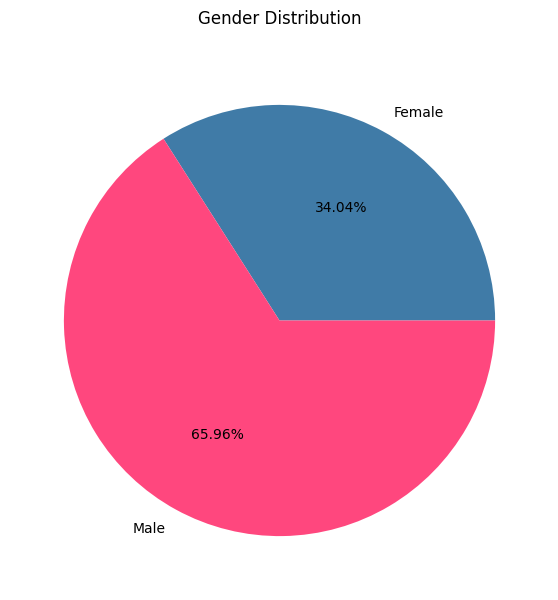

In [117]:
# Calculate gender distribution using PySpark
gender_distribution = df.groupBy('Gender').count().collect()

# Convert the result to a Pandas DataFrame for plotting
import pandas as pd
gender_distribution_df = pd.DataFrame(gender_distribution, columns=['Gender', 'Count'])

# Plot the pie chart using Matplotlib
plt.figure(figsize=(7, 7))
plt.pie(gender_distribution_df['Count'], labels=gender_distribution_df['Gender'], autopct='%1.2f%%', colors=['#407ba7', '#ff477e'])
plt.title("Gender Distribution", fontsize=12, pad=20)
plt.show()

### Histogram for Age Distribution

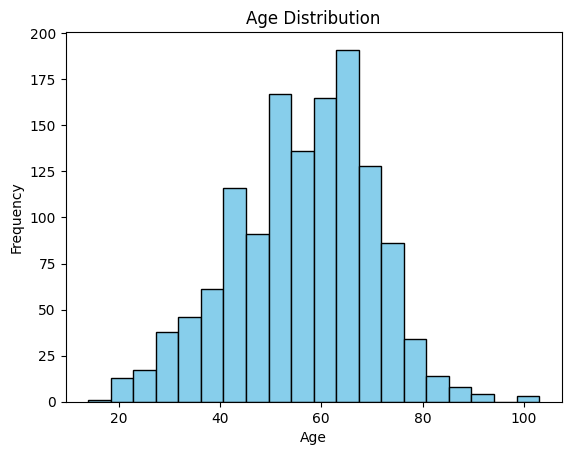

In [118]:
# Convert PySpark DataFrame to Pandas DataFrame
df2_pandas = df2.select('Age').toPandas()

# Plot histogram using Matplotlib
plt.hist(df2_pandas['Age'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.show()

### Histogram for Heart Rate Distribution

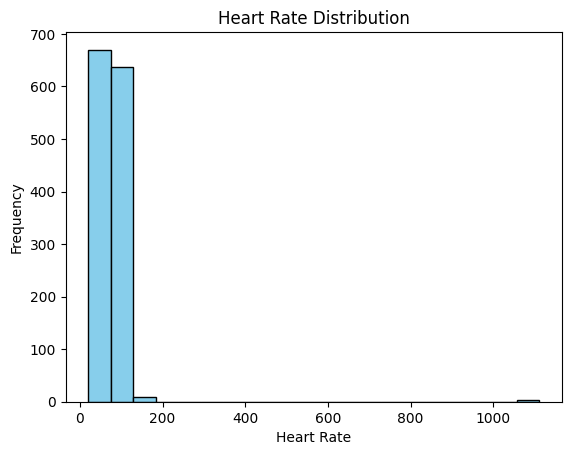

In [119]:
# Convert PySpark DataFrame to Pandas DataFrame
df2_pandas = df2.select('Heart rate').toPandas()

# Plot histogram using Matplotlib
plt.hist(df2_pandas['Heart rate'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Heart Rate')
plt.ylabel('Frequency')
plt.title('Heart Rate Distribution')
plt.show()

### Histogram of Systolic Blood Pressure

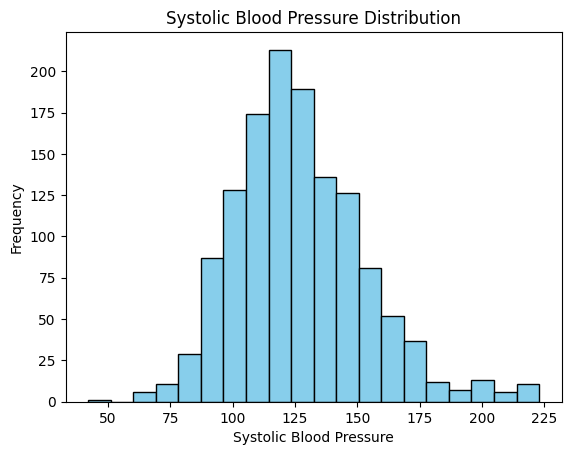

In [120]:
# Convert PySpark DataFrame to Pandas DataFrame
df2_pandas = df2.select('Systolic blood pressure').toPandas()

# Plot histogram using Matplotlib
plt.hist(df2_pandas['Systolic blood pressure'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Systolic Blood Pressure')
plt.ylabel('Frequency')
plt.title('Systolic Blood Pressure Distribution')
plt.show()

### Histogram of Diastolic Blood Pressure

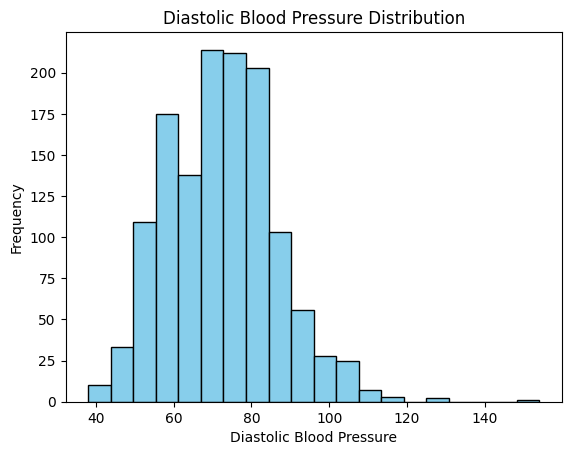

In [121]:
# Convert PySpark DataFrame to Pandas DataFrame
df2_pandas = df2.select('Diastolic blood pressure').toPandas()

# Plot histogram using Matplotlib
plt.hist(df2_pandas['Diastolic blood pressure'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Diastolic Blood Pressure')
plt.ylabel('Frequency')
plt.title('Diastolic Blood Pressure Distribution')
plt.show()

### Histogram of Blood Sugar

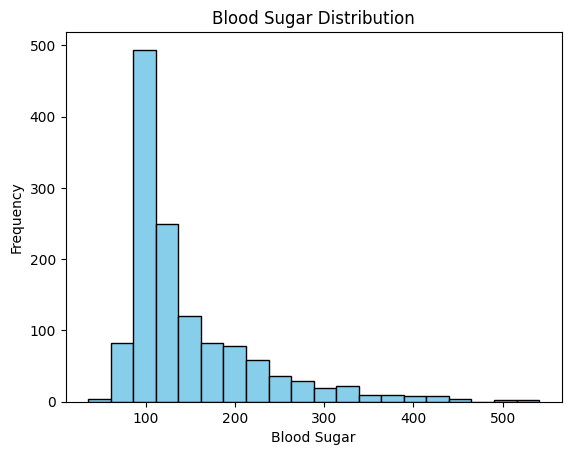

In [122]:
# Convert PySpark DataFrame to Pandas DataFrame
df2_pandas = df2.select('Blood sugar').toPandas()

# Plot histogram using Matplotlib
plt.hist(df2_pandas['Blood sugar'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Blood Sugar')
plt.ylabel('Frequency')
plt.title('Blood Sugar Distribution')
plt.show()

### Histogram of CK-MB

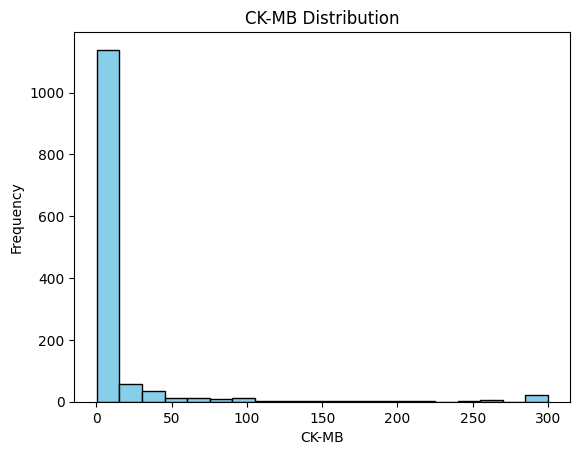

In [123]:
# Convert PySpark DataFrame to Pandas DataFrame
df2_pandas = df2.select('CK-MB').toPandas()

# Plot histogram using Matplotlib
plt.hist(df2_pandas['CK-MB'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('CK-MB')
plt.ylabel('Frequency')
plt.title('CK-MB Distribution')
plt.show()

### Histogram of Troponin

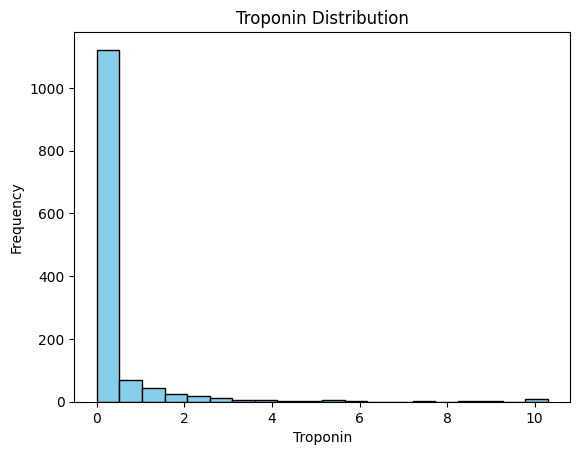

In [124]:
# Convert PySpark DataFrame to Pandas DataFrame
df2_pandas = df2.select('Troponin').toPandas()

# Plot histogram using Matplotlib
plt.hist(df2_pandas['Troponin'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Troponin')
plt.ylabel('Frequency')
plt.title('Troponin Distribution')
plt.show()

### Heatmap to know the correlation

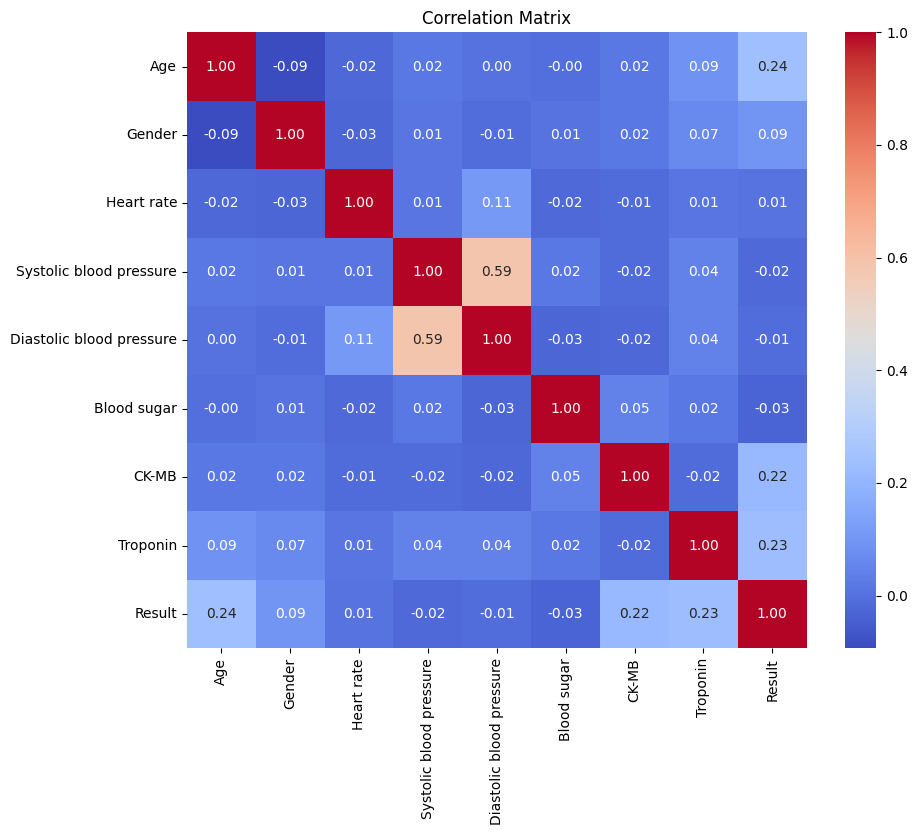

In [125]:
# Convert PySpark DataFrame to Pandas DataFrame
df2_pandas = df2.toPandas()

# Plot heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(df2_pandas.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Data Functioning for prediction

In [126]:
def AgeGroup(age):
    if age < 10:
        return 0
    elif age < 20:
        return 1
    elif age < 30:
        return 2
    elif age < 40:
        return 3
    elif age < 50:
        return 4
    elif age < 60:
        return 5
    elif age < 70:
        return 6
    elif age < 80:
        return 7
    elif age < 90:
        return 8
    elif age < 100:
        return 9
    else:
        return 10

In [127]:
# Create a UDF from the Python function
age_group_udf = udf(AgeGroup, IntegerType())

# Apply the UDF to the DataFrame and create a new column
df2 = df2.withColumn("AgeGroup", age_group_udf(df2["Age"]))

# Drop the original 'Age' column
df2 = df2.drop("Age")


### Conversion of Result into Numbers by checking for either positive or negative

In [128]:
df2 = df2.withColumn("Result", when(df2["Result"] == "positive", 1).when(df2["Result"] == "negative", 0).otherwise(df2["Result"]))


In [129]:
df2.show(5)

+------+----------+-----------------------+------------------------+-----------+-----+--------+------+--------+
|Gender|Heart rate|Systolic blood pressure|Diastolic blood pressure|Blood sugar|CK-MB|Troponin|Result|AgeGroup|
+------+----------+-----------------------+------------------------+-----------+-----+--------+------+--------+
|     1|        66|                    160|                      83|      160.0|  1.8|   0.012|     0|       6|
|     1|        94|                     98|                      46|      296.0| 6.75|    1.06|     1|       2|
|     1|        64|                    160|                      77|      270.0| 1.99|   0.003|     0|       5|
|     1|        70|                    120|                      55|      270.0|13.87|   0.122|     1|       6|
|     1|        64|                    112|                      65|      300.0| 1.08|   0.003|     0|       5|
+------+----------+-----------------------+------------------------+-----------+-----+--------+------+--

### Splitting x and y dataset

In [130]:
pandas_df = df2.toPandas()

# Split data into features (x) and target (y)
x = pandas_df.drop(columns=['Result'])
y = pandas_df['Result']

# Prediction

### Necessary Imports for Predictions

In [131]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


### Splitting into test and train sets for both x and y

In [132]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2)

### Using RandomForest for prediction and checking for accuracy score

In [133]:
rf = RandomForestClassifier()
rf.fit(x_train,y_train)
y_pred = rf.predict(x_test)
accuracy_score(y_test,y_pred)

0.9886363636363636

In [134]:
# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

Precision: 0.9878787878787879
Recall: 0.9939024390243902
F1-score: 0.9908814589665653


In [135]:
y_pred

array([1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1],
      dtype=int32)

In [136]:
y_test

426     1
980     1
105     0
134     1
130     0
       ..
131     1
595     0
1188    0
1067    1
906     1
Name: Result, Length: 264, dtype: int32

### Dataframe of prediction for actual result

In [137]:
# Convert y_pred and y_test to Pandas Series and reset their indices
y_pred_series = pd.Series(y_pred, name='Predicted_Result').reset_index(drop=True)
y_test_series = pd.Series(y_test, name='Actual_Result').reset_index(drop=True)

# Merge y_pred_series and y_test_series into a single DataFrame
predictions_df = pd.concat([y_test_series, y_pred_series], axis=1)

print(predictions_df)

     Actual_Result  Predicted_Result
0                1                 1
1                1                 1
2                0                 0
3                1                 1
4                0                 0
..             ...               ...
259              1                 1
260              0                 0
261              0                 0
262              1                 1
263              1                 1

[264 rows x 2 columns]


### Finding total number of correct and incorrect predictions

In [138]:
# Calculate correct predictions
correct_predictions = (predictions_df['Predicted_Result'] == predictions_df['Actual_Result'])

# Count the number of correct predictions
num_correct_predictions = correct_predictions.sum()



In [139]:
print("Number of Correct Predictions:", num_correct_predictions)

Number of Correct Predictions: 261


In [140]:
 num_incorrect_predictions = len(y_pred) - num_correct_predictions

In [141]:
print("Number of InCorrect Predictions:", num_incorrect_predictions)

Number of InCorrect Predictions: 3


### Random Prediction Taken

In [142]:
import random

# Randomly select a prediction from predictions_df
random_index = random.randint(0, len(predictions_df) - 1)
random_prediction = predictions_df.iloc[random_index]

# Print the random prediction and actual value
print("Random Prediction:\n", random_prediction)


Random Prediction:
 Actual_Result       1
Predicted_Result    0
Name: 186, dtype: int32


### Evaluation with Logistic Regression (same Accuracy)
Can use any

In [143]:
from sklearn.linear_model import LogisticRegression

# Initialize=ing Logistic Regression model
log_reg = LogisticRegression()

# Train the model
log_reg.fit(x_train, y_train)

# Make predictions
y_prediction = log_reg.predict(x_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_prediction)
print("Accuracy:", accuracy)

Accuracy: 0.7916666666666666


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
